In [1]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mamba_ssm import Mamba

In [2]:
!nvidia-smi

Wed Feb 21 17:50:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   32C    P8              20W / 215W |   2262MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from torch.nn.utils.rnn import pad_sequence

In [7]:
data_dir = "../data/data_preprocessed/crema_d/preprocessed/" 
data_x = np.load(f"{data_dir}crema_d.trill_embedding.train.npy", allow_pickle=True)
data_x.shape

(5144, 2048)

In [8]:
x_train = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_train = pad_sequence(x_train, batch_first=True)
x_train.shape

torch.Size([5144, 2048])

In [9]:
data_x = np.load(f"{data_dir}crema_d.trill_embedding.test.npy", allow_pickle=True)
x_test = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_test = pad_sequence(x_test, batch_first=True)
x_test.shape

torch.Size([1556, 2048])

In [10]:
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)
print(classnames)

['NEU' 'HAP' 'SAD' 'ANG' 'FEA' 'DIS']


In [11]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5], dtype=int16)

In [12]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

torch.Size([3387, 2048])
torch.Size([1025, 2048])


In [13]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = x_train[:, None ,:]
    y_train = torch.tensor(y_train, dtype=torch.int64)
    x_test = x_test[:, None, :]
    y_test = torch.tensor(y_test, dtype=torch.int64)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [14]:
batch_size = 16
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [15]:
from IConNet.nn.model import M12
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M12_debug
description: FirConv sequential for iemocap
fe:
  n_block: 2
  n_channel:
  - 64
  - 32
  kernel_size:
  - 63
  - 31
  stride:
  - 4
  - 4
  window_k:
  - 5
  - 9
  residual_connection_type: stack
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 48
  pooling: max
  use_context: false
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
         

In [16]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [17]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [18]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▏                                                                                                                                                                             | 0.007272727272727273/10 [00:00<12:14, 73.52s/it]

Train Epoch: 1 [0/3387 (0%)]	Loss: 1.377795
Mem before-during-after: 529408 57448448 20813312


  2%|██▋                                                                                                                                                                            | 0.15272727272727266/10 [00:06<07:02, 42.92s/it]

Train Epoch: 1 [640/3387 (19%)]	Loss: 1.374426
Mem before-during-after: 20813312 67582464 20813312


  3%|█████▏                                                                                                                                                                          | 0.2981818181818183/10 [00:13<07:00, 43.39s/it]

Train Epoch: 1 [1280/3387 (38%)]	Loss: 1.396900
Mem before-during-after: 20813312 67582464 20813312


  4%|███████▊                                                                                                                                                                        | 0.4436363636363647/10 [00:19<06:53, 43.24s/it]

Train Epoch: 1 [1920/3387 (57%)]	Loss: 1.379001
Mem before-during-after: 20813312 67582464 20813312


  6%|██████████▎                                                                                                                                                                     | 0.5890909090909111/10 [00:25<06:40, 42.54s/it]

Train Epoch: 1 [2560/3387 (76%)]	Loss: 1.391945
Mem before-during-after: 20813312 67582464 20813312


  7%|████████████▉                                                                                                                                                                   | 0.7345454545454575/10 [00:32<06:35, 42.67s/it]

Train Epoch: 1 [3200/3387 (95%)]	Loss: 1.414638
Mem before-during-after: 20813312 67582464 20813312


 10%|█████████████████▋                                                                                                                                                              | 1.0036363636363683/10 [00:43<06:23, 42.65s/it]


Test Epoch: 1	Accuracy: 266/1024 (26%)

Train Epoch: 2 [0/3387 (0%)]	Loss: 1.411799
Mem before-during-after: 20809216 67549696 20813312


 12%|████████████████████▎                                                                                                                                                           | 1.1527272727272784/10 [00:49<06:24, 43.51s/it]

Train Epoch: 2 [640/3387 (19%)]	Loss: 1.367809
Mem before-during-after: 20813312 67582464 20813312


 13%|██████████████████████▊                                                                                                                                                         | 1.2981818181818248/10 [00:56<06:09, 42.44s/it]

Train Epoch: 2 [1280/3387 (38%)]	Loss: 1.367315
Mem before-during-after: 20813312 67582464 20813312


 14%|█████████████████████████▍                                                                                                                                                      | 1.4436363636363712/10 [01:02<05:54, 41.47s/it]

Train Epoch: 2 [1920/3387 (57%)]	Loss: 1.400432
Mem before-during-after: 20813312 67582464 20813312


 16%|███████████████████████████▉                                                                                                                                                    | 1.5890909090909175/10 [01:08<05:55, 42.27s/it]

Train Epoch: 2 [2560/3387 (76%)]	Loss: 1.331806
Mem before-during-after: 20813312 67582464 20813312


 17%|██████████████████████████████▋                                                                                                                                                  | 1.734545454545464/10 [01:14<05:50, 42.36s/it]

Train Epoch: 2 [3200/3387 (95%)]	Loss: 1.290818
Mem before-during-after: 20813312 67582464 20813312


 20%|███████████████████████████████████▎                                                                                                                                            | 2.0036363636363745/10 [01:26<05:33, 41.75s/it]


Test Epoch: 2	Accuracy: 317/1024 (31%)

Train Epoch: 3 [0/3387 (0%)]	Loss: 1.292667
Mem before-during-after: 20809216 67549696 20813312


 22%|█████████████████████████████████████▉                                                                                                                                          | 2.1527272727272755/10 [01:32<05:40, 43.39s/it]

Train Epoch: 3 [640/3387 (19%)]	Loss: 1.126521
Mem before-during-after: 20813312 67582464 20813312


 23%|████████████████████████████████████████▋                                                                                                                                        | 2.298181818181813/10 [01:38<05:31, 43.09s/it]

Train Epoch: 3 [1280/3387 (38%)]	Loss: 1.243106
Mem before-during-after: 20813312 67582464 20813312


 24%|███████████████████████████████████████████                                                                                                                                     | 2.4436363636363505/10 [01:44<05:22, 42.72s/it]

Train Epoch: 3 [1920/3387 (57%)]	Loss: 1.233959
Mem before-during-after: 20813312 67582464 20813312


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 2.589090909090888/10 [01:51<05:16, 42.70s/it]

Train Epoch: 3 [2560/3387 (76%)]	Loss: 1.314065
Mem before-during-after: 20813312 67582464 20813312


 27%|████████████████████████████████████████████████▏                                                                                                                               | 2.7345454545454255/10 [01:57<05:05, 42.01s/it]

Train Epoch: 3 [3200/3387 (95%)]	Loss: 1.187943
Mem before-during-after: 20813312 67582464 20813312


 30%|█████████████████████████████████████████████████████▍                                                                                                                            | 3.00363636363632/10 [02:08<04:54, 42.05s/it]


Test Epoch: 3	Accuracy: 537/1024 (52%)

Train Epoch: 4 [0/3387 (0%)]	Loss: 1.116990
Mem before-during-after: 20809216 67549696 20813312


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 3.152727272727221/10 [02:14<04:52, 42.78s/it]

Train Epoch: 4 [640/3387 (19%)]	Loss: 1.073582
Mem before-during-after: 20813312 67582464 20813312


 33%|██████████████████████████████████████████████████████████                                                                                                                      | 3.2981818181817584/10 [02:21<04:42, 42.09s/it]

Train Epoch: 4 [1280/3387 (38%)]	Loss: 1.094732
Mem before-during-after: 20813312 67582464 20813312


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 3.443636363636296/10 [02:27<04:41, 42.94s/it]

Train Epoch: 4 [1920/3387 (57%)]	Loss: 0.905862
Mem before-during-after: 20813312 67582464 20813312


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                | 3.5890909090908334/10 [02:33<04:28, 41.96s/it]

Train Epoch: 4 [2560/3387 (76%)]	Loss: 1.056256
Mem before-during-after: 20813312 67582464 20813312


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 3.734545454545371/10 [02:39<04:33, 43.64s/it]

Train Epoch: 4 [3200/3387 (95%)]	Loss: 0.974414
Mem before-during-after: 20813312 67582464 20813312


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 4.003636363636265/10 [02:50<04:05, 40.88s/it]


Test Epoch: 4	Accuracy: 533/1024 (52%)

Train Epoch: 5 [0/3387 (0%)]	Loss: 1.270797
Mem before-during-after: 20809216 67549696 20813312


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                       | 4.1527272727271844/10 [02:57<04:02, 41.44s/it]

Train Epoch: 5 [640/3387 (19%)]	Loss: 1.046317
Mem before-during-after: 20813312 67582464 20813312


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 4.29818181818174/10 [03:03<04:00, 42.26s/it]

Train Epoch: 5 [1280/3387 (38%)]	Loss: 0.875638
Mem before-during-after: 20813312 67582464 20813312


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 4.443636363636295/10 [03:09<03:55, 42.34s/it]

Train Epoch: 5 [1920/3387 (57%)]	Loss: 1.433824
Mem before-during-after: 20813312 67582464 20813312


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 4.58909090909085/10 [03:15<03:43, 41.31s/it]

Train Epoch: 5 [2560/3387 (76%)]	Loss: 1.007363
Mem before-during-after: 20813312 67582464 20813312


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 4.7345454545454055/10 [03:21<03:45, 42.91s/it]

Train Epoch: 5 [3200/3387 (95%)]	Loss: 1.294969
Mem before-during-after: 20813312 67582464 20813312


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5.003636363636333/10 [03:32<03:39, 43.85s/it]


Test Epoch: 5	Accuracy: 536/1024 (52%)

Train Epoch: 6 [0/3387 (0%)]	Loss: 1.319820
Mem before-during-after: 20809216 67549696 20813312


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 5.152727272727252/10 [03:39<03:27, 42.86s/it]

Train Epoch: 6 [640/3387 (19%)]	Loss: 1.571920
Mem before-during-after: 20813312 67582464 20813312


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 5.298181818181807/10 [03:45<03:22, 43.04s/it]

Train Epoch: 6 [1280/3387 (38%)]	Loss: 1.564631
Mem before-during-after: 20813312 67582464 20813312


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 5.4436363636363625/10 [03:51<03:21, 44.17s/it]

Train Epoch: 6 [1920/3387 (57%)]	Loss: 0.915568
Mem before-during-after: 20813312 67582464 20813312


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 5.589090909090918/10 [03:57<03:04, 41.73s/it]

Train Epoch: 6 [2560/3387 (76%)]	Loss: 1.112807
Mem before-during-after: 20813312 67582464 20813312


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5.734545454545473/10 [04:04<02:57, 41.62s/it]

Train Epoch: 6 [3200/3387 (95%)]	Loss: 1.091099
Mem before-during-after: 20813312 67582464 20813312


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 6.0036363636364/10 [04:14<02:41, 40.45s/it]


Test Epoch: 6	Accuracy: 485/1024 (47%)

Train Epoch: 7 [0/3387 (0%)]	Loss: 1.252399
Mem before-during-after: 20809216 67549696 20813312


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 6.1527272727273195/10 [04:21<02:45, 42.99s/it]

Train Epoch: 7 [640/3387 (19%)]	Loss: 1.409300
Mem before-during-after: 20813312 67582464 20813312


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 6.298181818181875/10 [04:27<02:32, 41.21s/it]

Train Epoch: 7 [1280/3387 (38%)]	Loss: 1.143350
Mem before-during-after: 20813312 67582464 20813312


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 6.44363636363643/10 [04:33<02:26, 41.06s/it]

Train Epoch: 7 [1920/3387 (57%)]	Loss: 1.146609
Mem before-during-after: 20813312 67582464 20813312


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6.589090909090985/10 [04:39<02:25, 42.52s/it]

Train Epoch: 7 [2560/3387 (76%)]	Loss: 1.191893
Mem before-during-after: 20813312 67582464 20813312


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6.7345454545455405/10 [04:45<02:39, 48.75s/it]

Train Epoch: 7 [3200/3387 (95%)]	Loss: 0.917877
Mem before-during-after: 20813312 67582464 20813312


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.003636363636468/10 [04:56<02:02, 40.80s/it]


Test Epoch: 7	Accuracy: 541/1024 (53%)

Train Epoch: 8 [0/3387 (0%)]	Loss: 0.867222
Mem before-during-after: 20809216 67549696 20813312


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7.152727272727387/10 [05:02<01:58, 41.71s/it]

Train Epoch: 8 [640/3387 (19%)]	Loss: 0.709401
Mem before-during-after: 20813312 67582464 20813312


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 7.298181818181942/10 [05:08<01:52, 41.71s/it]

Train Epoch: 8 [1280/3387 (38%)]	Loss: 1.158780
Mem before-during-after: 20813312 67582464 20813312


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 7.4436363636364975/10 [05:15<01:48, 42.39s/it]

Train Epoch: 8 [1920/3387 (57%)]	Loss: 1.439681
Mem before-during-after: 20813312 67582464 20813312


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7.589090909091053/10 [05:21<01:41, 42.27s/it]

Train Epoch: 8 [2560/3387 (76%)]	Loss: 1.362303
Mem before-during-after: 20813312 67582464 20813312


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7.734545454545608/10 [05:27<01:34, 41.66s/it]

Train Epoch: 8 [3200/3387 (95%)]	Loss: 0.937183
Mem before-during-after: 20813312 67582464 20813312


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 8.003636363636534/10 [05:38<01:21, 40.79s/it]


Test Epoch: 8	Accuracy: 554/1024 (54%)

Train Epoch: 9 [0/3387 (0%)]	Loss: 0.977861
Mem before-during-after: 20809216 67549696 20813312


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 8.152727272727454/10 [05:44<01:18, 42.75s/it]

Train Epoch: 9 [640/3387 (19%)]	Loss: 0.860624
Mem before-during-after: 20813312 67582464 20813312


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8.298181818182009/10 [05:51<01:12, 42.59s/it]

Train Epoch: 9 [1280/3387 (38%)]	Loss: 0.913072
Mem before-during-after: 20813312 67582464 20813312


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8.443636363636564/10 [05:57<01:07, 43.52s/it]

Train Epoch: 9 [1920/3387 (57%)]	Loss: 1.077910
Mem before-during-after: 20813312 67582464 20813312


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8.58909090909112/10 [06:03<01:00, 42.77s/it]

Train Epoch: 9 [2560/3387 (76%)]	Loss: 1.152893
Mem before-during-after: 20813312 67582464 20813312


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8.734545454545675/10 [06:09<00:52, 41.62s/it]

Train Epoch: 9 [3200/3387 (95%)]	Loss: 0.983064
Mem before-during-after: 20813312 67582464 20813312


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9.003636363636602/10 [06:20<00:40, 40.91s/it]


Test Epoch: 9	Accuracy: 486/1024 (47%)

Train Epoch: 10 [0/3387 (0%)]	Loss: 0.945338
Mem before-during-after: 20809216 67549696 20813312


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9.152727272727521/10 [06:26<00:35, 41.48s/it]

Train Epoch: 10 [640/3387 (19%)]	Loss: 1.084177
Mem before-during-after: 20813312 67582464 20813312


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9.298181818182076/10 [06:33<00:29, 42.59s/it]

Train Epoch: 10 [1280/3387 (38%)]	Loss: 1.221536
Mem before-during-after: 20813312 67582464 20813312


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9.443636363636632/10 [06:39<00:23, 41.35s/it]

Train Epoch: 10 [1920/3387 (57%)]	Loss: 0.976729
Mem before-during-after: 20813312 67582464 20813312


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9.589090909091187/10 [06:45<00:17, 43.26s/it]

Train Epoch: 10 [2560/3387 (76%)]	Loss: 1.199216
Mem before-during-after: 20813312 67582464 20813312


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9.734545454545742/10 [06:51<00:11, 43.65s/it]

Train Epoch: 10 [3200/3387 (95%)]	Loss: 1.050074
Mem before-during-after: 20813312 67582464 20813312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.996363636363942/10 [07:02<00:00, 41.34s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.000000000000306/10 [07:02<00:00, 42.29s/it]


Test Epoch: 10	Accuracy: 541/1024 (53%)



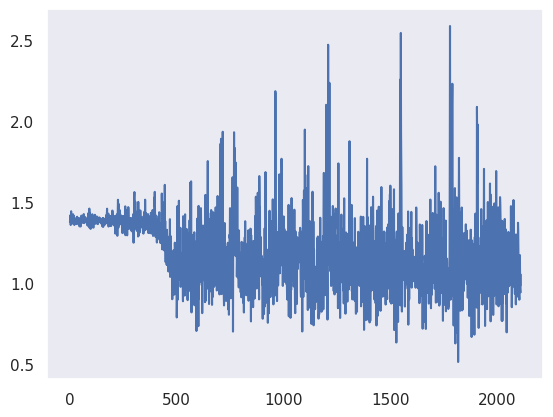

In [19]:
plt.plot(train_losses)

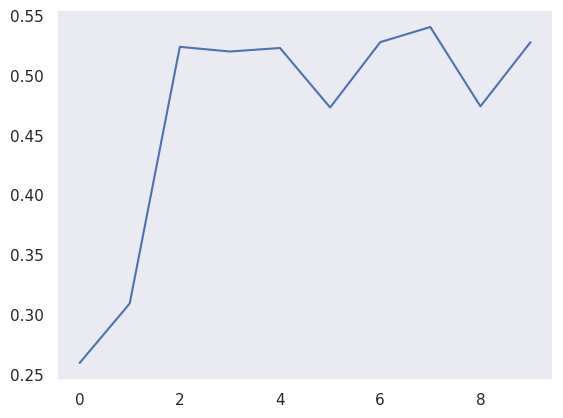

In [20]:
plt.plot(test_accuracy)

In [21]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [22]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 542/1024 (0.5293)
{'acc_detail': tensor([0.6128, 0.3596, 0.5303, 0.5902], device='cuda:0'),
 'acc_unweighted': tensor(0.5232, device='cuda:0'),
 'acc_weighted': tensor(0.5293, device='cuda:0'),
 'f1s': tensor(0.5336, device='cuda:0'),
 'f1s_detail': tensor([0.6667, 0.3761, 0.6278, 0.4638], device='cuda:0'),
 'precision_detail': tensor([0.7309, 0.3942, 0.7692, 0.3820], device='cuda:0'),
 'recall_detail': tensor([0.6128, 0.3596, 0.5303, 0.5902], device='cuda:0'),
 'rocauc': tensor([0.9007, 0.7018, 0.8876, 0.6684], device='cuda:0'),
 'uar': tensor(0.5232, device='cuda:0'),
 'wap': tensor(0.5752, device='cuda:0')}


tensor([[163,   8,   0,  95],
        [  6,  82,  26, 114],
        [  2,  77, 140,  45],
        [ 52,  41,  16, 157]], device='cuda:0')

In [23]:
model_path = '../models_cremad3/cremad_label4_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [24]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad4/cremad_label4_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.007272727272727273/50 [00:00<42:07, 50.56s/it]

Train Epoch: 11 [0/3387 (0%)]	Loss: 1.297237
Mem before-during-after: 19842560 66583040 20901376


  0%|▌                                                                                                                                                                              | 0.15272727272727266/50 [00:07<38:53, 46.82s/it]

Train Epoch: 11 [640/3387 (19%)]	Loss: 1.052914
Mem before-during-after: 20901376 67670528 20901376


  1%|█                                                                                                                                                                               | 0.2981818181818183/50 [00:14<38:39, 46.67s/it]

Train Epoch: 11 [1280/3387 (38%)]	Loss: 0.964729
Mem before-during-after: 20901376 67670528 20901376


  1%|█▌                                                                                                                                                                              | 0.4436363636363647/50 [00:21<39:36, 47.95s/it]

Train Epoch: 11 [1920/3387 (57%)]	Loss: 1.169921
Mem before-during-after: 20901376 67670528 20901376


  1%|██                                                                                                                                                                              | 0.5890909090909111/50 [00:27<39:40, 48.18s/it]

Train Epoch: 11 [2560/3387 (76%)]	Loss: 1.155440
Mem before-during-after: 20901376 67670528 20901376


  1%|██▌                                                                                                                                                                             | 0.7345454545454575/50 [00:34<38:05, 46.39s/it]

Train Epoch: 11 [3200/3387 (95%)]	Loss: 1.117165
Mem before-during-after: 20901376 67670528 20901376


  2%|███▌                                                                                                                                                                            | 1.0036363636363683/50 [00:47<37:11, 45.53s/it]


Test Epoch: 11	Accuracy: 564/1024 (55%)

saved model: ../models_cremad4/cremad_label4_m12new_best_11epoch.pt
Train Epoch: 12 [0/3387 (0%)]	Loss: 0.903225
Mem before-during-after: 20897280 67637760 20901376


  2%|████                                                                                                                                                                            | 1.1527272727272784/50 [00:54<37:43, 46.34s/it]

Train Epoch: 12 [640/3387 (19%)]	Loss: 0.920236
Mem before-during-after: 20901376 67670528 20901376


  3%|████▌                                                                                                                                                                           | 1.2981818181818248/50 [01:00<37:53, 46.67s/it]

Train Epoch: 12 [1280/3387 (38%)]	Loss: 0.926025
Mem before-during-after: 20901376 67670528 20901376


  3%|█████                                                                                                                                                                           | 1.4436363636363712/50 [01:07<38:16, 47.30s/it]

Train Epoch: 12 [1920/3387 (57%)]	Loss: 1.085978
Mem before-during-after: 20901376 67670528 20901376


  3%|█████▌                                                                                                                                                                          | 1.5890909090909175/50 [01:14<38:00, 47.12s/it]

Train Epoch: 12 [2560/3387 (76%)]	Loss: 1.251571
Mem before-during-after: 20901376 67670528 20901376


  3%|██████▏                                                                                                                                                                          | 1.734545454545464/50 [01:21<37:33, 46.68s/it]

Train Epoch: 12 [3200/3387 (95%)]	Loss: 1.064070
Mem before-during-after: 20901376 67670528 20901376


  4%|███████                                                                                                                                                                         | 2.0036363636363745/50 [01:33<36:45, 45.95s/it]


Test Epoch: 12	Accuracy: 540/1024 (53%)

Train Epoch: 13 [0/3387 (0%)]	Loss: 1.007611
Mem before-during-after: 20897280 67637760 20901376


  4%|███████▌                                                                                                                                                                        | 2.1527272727272755/50 [01:40<37:22, 46.88s/it]

Train Epoch: 13 [640/3387 (19%)]	Loss: 1.155510
Mem before-during-after: 20901376 67670528 20901376


  5%|████████▏                                                                                                                                                                        | 2.298181818181813/50 [01:47<37:42, 47.43s/it]

Train Epoch: 13 [1280/3387 (38%)]	Loss: 1.041550
Mem before-during-after: 20901376 67670528 20901376


  5%|████████▌                                                                                                                                                                       | 2.4436363636363505/50 [01:54<37:02, 46.73s/it]

Train Epoch: 13 [1920/3387 (57%)]	Loss: 1.001057
Mem before-during-after: 20901376 67670528 20901376


  5%|█████████▏                                                                                                                                                                       | 2.589090909090888/50 [02:01<37:08, 47.01s/it]

Train Epoch: 13 [2560/3387 (76%)]	Loss: 1.205683
Mem before-during-after: 20901376 67670528 20901376


  5%|█████████▋                                                                                                                                                                      | 2.7345454545454255/50 [02:08<37:03, 47.03s/it]

Train Epoch: 13 [3200/3387 (95%)]	Loss: 1.167415
Mem before-during-after: 20901376 67670528 20901376


  6%|██████████▋                                                                                                                                                                       | 3.00363636363632/50 [02:20<35:47, 45.70s/it]


Test Epoch: 13	Accuracy: 520/1024 (51%)

Train Epoch: 14 [0/3387 (0%)]	Loss: 1.198017
Mem before-during-after: 20897280 67637760 20901376


  6%|███████████▏                                                                                                                                                                     | 3.152727272727221/50 [02:27<36:47, 47.12s/it]

Train Epoch: 14 [640/3387 (19%)]	Loss: 1.048839
Mem before-during-after: 20901376 67670528 20901376


  7%|███████████▌                                                                                                                                                                    | 3.2981818181817584/50 [02:34<36:21, 46.71s/it]

Train Epoch: 14 [1280/3387 (38%)]	Loss: 1.053368
Mem before-during-after: 20901376 67670528 20901376


  7%|████████████▏                                                                                                                                                                    | 3.443636363636296/50 [02:41<36:26, 46.97s/it]

Train Epoch: 14 [1920/3387 (57%)]	Loss: 0.990620
Mem before-during-after: 20901376 67670528 20901376


  7%|████████████▋                                                                                                                                                                   | 3.5890909090908334/50 [02:48<36:48, 47.58s/it]

Train Epoch: 14 [2560/3387 (76%)]	Loss: 1.011881
Mem before-during-after: 20901376 67670528 20901376


  7%|█████████████▏                                                                                                                                                                   | 3.734545454545371/50 [02:55<36:31, 47.37s/it]

Train Epoch: 14 [3200/3387 (95%)]	Loss: 1.376244
Mem before-during-after: 20901376 67670528 20901376


  8%|██████████████▏                                                                                                                                                                  | 4.003636363636265/50 [03:07<36:25, 47.51s/it]


Test Epoch: 14	Accuracy: 525/1024 (51%)

Train Epoch: 15 [0/3387 (0%)]	Loss: 1.174716
Mem before-during-after: 20897280 67637760 20901376


  8%|██████████████▌                                                                                                                                                                 | 4.1527272727271844/50 [03:14<35:29, 46.45s/it]

Train Epoch: 15 [640/3387 (19%)]	Loss: 0.931229
Mem before-during-after: 20901376 67670528 20901376


  9%|███████████████▎                                                                                                                                                                  | 4.29818181818174/50 [03:21<35:23, 46.47s/it]

Train Epoch: 15 [1280/3387 (38%)]	Loss: 1.383000
Mem before-during-after: 20901376 67670528 20901376


  9%|███████████████▋                                                                                                                                                                 | 4.443636363636295/50 [03:28<35:41, 47.00s/it]

Train Epoch: 15 [1920/3387 (57%)]	Loss: 0.705379
Mem before-during-after: 20901376 67670528 20901376


  9%|████████████████▎                                                                                                                                                                 | 4.58909090909085/50 [03:35<35:22, 46.74s/it]

Train Epoch: 15 [2560/3387 (76%)]	Loss: 1.642656
Mem before-during-after: 20901376 67670528 20901376


  9%|████████████████▋                                                                                                                                                               | 4.7345454545454055/50 [03:42<35:30, 47.06s/it]

Train Epoch: 15 [3200/3387 (95%)]	Loss: 2.273494
Mem before-during-after: 20901376 67670528 20901376


 10%|█████████████████▋                                                                                                                                                               | 5.003636363636333/50 [03:54<34:53, 46.52s/it]


Test Epoch: 15	Accuracy: 424/1024 (41%)

Train Epoch: 16 [0/3387 (0%)]	Loss: 1.257752
Mem before-during-after: 20897280 67637760 20901376


 10%|██████████████████▏                                                                                                                                                              | 5.152727272727252/50 [04:01<35:23, 47.36s/it]

Train Epoch: 16 [640/3387 (19%)]	Loss: 1.130981
Mem before-during-after: 20901376 67670528 20901376


 11%|██████████████████▊                                                                                                                                                              | 5.298181818181807/50 [04:08<35:28, 47.61s/it]

Train Epoch: 16 [1280/3387 (38%)]	Loss: 1.048287
Mem before-during-after: 20901376 67670528 20901376


 11%|███████████████████▎                                                                                                                                                             | 5.439999999999999/50 [04:15<35:21, 47.60s/it]

Train Epoch: 16 [1920/3387 (57%)]	Loss: 1.377108
Mem before-during-after: 20901376 67670528 20901376


 11%|███████████████████▊                                                                                                                                                             | 5.589090909090918/50 [04:22<34:13, 46.25s/it]

Train Epoch: 16 [2560/3387 (76%)]	Loss: 1.303834
Mem before-during-after: 20901376 67670528 20901376


 11%|████████████████████▎                                                                                                                                                            | 5.734545454545473/50 [04:29<34:15, 46.45s/it]

Train Epoch: 16 [3200/3387 (95%)]	Loss: 1.046858
Mem before-during-after: 20901376 67670528 20901376


 12%|█████████████████████▍                                                                                                                                                             | 6.0036363636364/50 [04:41<33:36, 45.84s/it]


Test Epoch: 16	Accuracy: 540/1024 (53%)

Train Epoch: 17 [0/3387 (0%)]	Loss: 1.191986
Mem before-during-after: 20897280 67637760 20901376


 12%|█████████████████████▋                                                                                                                                                          | 6.1527272727273195/50 [04:48<35:10, 48.12s/it]

Train Epoch: 17 [640/3387 (19%)]	Loss: 1.315748
Mem before-during-after: 20901376 67670528 20901376


 13%|██████████████████████▎                                                                                                                                                          | 6.298181818181875/50 [04:55<34:49, 47.81s/it]

Train Epoch: 17 [1280/3387 (38%)]	Loss: 0.899369
Mem before-during-after: 20901376 67670528 20901376


 13%|██████████████████████▉                                                                                                                                                           | 6.44363636363643/50 [05:02<34:15, 47.19s/it]

Train Epoch: 17 [1920/3387 (57%)]	Loss: 1.072617
Mem before-during-after: 20901376 67670528 20901376


 13%|███████████████████████▎                                                                                                                                                         | 6.589090909090985/50 [05:09<33:26, 46.22s/it]

Train Epoch: 17 [2560/3387 (76%)]	Loss: 0.965476
Mem before-during-after: 20901376 67670528 20901376


 13%|███████████████████████▋                                                                                                                                                        | 6.7345454545455405/50 [05:15<33:11, 46.03s/it]

Train Epoch: 17 [3200/3387 (95%)]	Loss: 0.910001
Mem before-during-after: 20901376 67670528 20901376


 14%|████████████████████████▊                                                                                                                                                        | 7.003636363636468/50 [05:28<32:50, 45.84s/it]


Test Epoch: 17	Accuracy: 447/1024 (44%)

Train Epoch: 18 [0/3387 (0%)]	Loss: 1.375248
Mem before-during-after: 20897280 67637760 20901376


 14%|█████████████████████████▎                                                                                                                                                       | 7.152727272727387/50 [05:35<33:05, 46.35s/it]

Train Epoch: 18 [640/3387 (19%)]	Loss: 1.015807
Mem before-during-after: 20901376 67670528 20901376


 15%|█████████████████████████▊                                                                                                                                                       | 7.298181818181942/50 [05:41<32:49, 46.12s/it]

Train Epoch: 18 [1280/3387 (38%)]	Loss: 0.888424
Mem before-during-after: 20901376 67670528 20901376


 15%|██████████████████████████▏                                                                                                                                                     | 7.4436363636364975/50 [05:48<32:51, 46.32s/it]

Train Epoch: 18 [1920/3387 (57%)]	Loss: 1.581529
Mem before-during-after: 20901376 67670528 20901376


 15%|██████████████████████████▊                                                                                                                                                      | 7.589090909091053/50 [05:55<33:29, 47.39s/it]

Train Epoch: 18 [2560/3387 (76%)]	Loss: 1.075271
Mem before-during-after: 20901376 67670528 20901376


 15%|███████████████████████████▍                                                                                                                                                     | 7.734545454545608/50 [06:02<33:20, 47.33s/it]

Train Epoch: 18 [3200/3387 (95%)]	Loss: 1.209863
Mem before-during-after: 20901376 67670528 20901376


 16%|████████████████████████████▎                                                                                                                                                    | 8.003636363636534/50 [06:14<32:29, 46.43s/it]


Test Epoch: 18	Accuracy: 494/1024 (48%)

Train Epoch: 19 [0/3387 (0%)]	Loss: 1.050186
Mem before-during-after: 20897280 67637760 20901376


 16%|████████████████████████████▊                                                                                                                                                    | 8.152727272727454/50 [06:21<32:16, 46.28s/it]

Train Epoch: 19 [640/3387 (19%)]	Loss: 0.938535
Mem before-during-after: 20901376 67670528 20901376


 17%|█████████████████████████████▍                                                                                                                                                   | 8.298181818182009/50 [06:28<32:47, 47.17s/it]

Train Epoch: 19 [1280/3387 (38%)]	Loss: 0.951395
Mem before-during-after: 20901376 67670528 20901376


 17%|█████████████████████████████▉                                                                                                                                                   | 8.443636363636564/50 [06:35<32:31, 46.97s/it]

Train Epoch: 19 [1920/3387 (57%)]	Loss: 0.953680
Mem before-during-after: 20901376 67670528 20901376


 17%|██████████████████████████████▌                                                                                                                                                   | 8.58909090909112/50 [06:42<33:18, 48.25s/it]

Train Epoch: 19 [2560/3387 (76%)]	Loss: 1.084929
Mem before-during-after: 20901376 67670528 20901376


 17%|██████████████████████████████▉                                                                                                                                                  | 8.734545454545675/50 [06:49<32:23, 47.09s/it]

Train Epoch: 19 [3200/3387 (95%)]	Loss: 1.461206
Mem before-during-after: 20901376 67670528 20901376


 18%|███████████████████████████████▊                                                                                                                                                 | 9.003636363636602/50 [07:01<31:43, 46.43s/it]


Test Epoch: 19	Accuracy: 556/1024 (54%)

Train Epoch: 20 [0/3387 (0%)]	Loss: 0.892668
Mem before-during-after: 20897280 67637760 20901376


 18%|████████████████████████████████▍                                                                                                                                                | 9.152727272727521/50 [07:08<32:23, 47.57s/it]

Train Epoch: 20 [640/3387 (19%)]	Loss: 1.070279
Mem before-during-after: 20901376 67670528 20901376


 19%|████████████████████████████████▉                                                                                                                                                | 9.298181818182076/50 [07:15<32:04, 47.28s/it]

Train Epoch: 20 [1280/3387 (38%)]	Loss: 1.053984
Mem before-during-after: 20901376 67670528 20901376


 19%|█████████████████████████████████▍                                                                                                                                               | 9.443636363636632/50 [07:22<32:13, 47.68s/it]

Train Epoch: 20 [1920/3387 (57%)]	Loss: 1.236646
Mem before-during-after: 20901376 67670528 20901376


 19%|█████████████████████████████████▉                                                                                                                                               | 9.589090909091187/50 [07:29<31:11, 46.31s/it]

Train Epoch: 20 [2560/3387 (76%)]	Loss: 1.116217
Mem before-during-after: 20901376 67670528 20901376


 19%|██████████████████████████████████▍                                                                                                                                              | 9.734545454545742/50 [07:36<30:58, 46.15s/it]

Train Epoch: 20 [3200/3387 (95%)]	Loss: 1.259811
Mem before-during-after: 20901376 67670528 20901376


 20%|███████████████████████████████████▍                                                                                                                                             | 10.00363636363667/50 [07:48<30:19, 45.48s/it]


Test Epoch: 20	Accuracy: 559/1024 (55%)

Train Epoch: 21 [0/3387 (0%)]	Loss: 0.996246
Mem before-during-after: 20897280 67637760 20901376


 20%|███████████████████████████████████▋                                                                                                                                            | 10.152727272727589/50 [07:55<30:48, 46.38s/it]

Train Epoch: 21 [640/3387 (19%)]	Loss: 1.050189
Mem before-during-after: 20901376 67670528 20901376


 21%|████████████████████████████████████▏                                                                                                                                           | 10.298181818182144/50 [08:02<30:40, 46.35s/it]

Train Epoch: 21 [1280/3387 (38%)]	Loss: 0.962718
Mem before-during-after: 20901376 67670528 20901376


 21%|█████████████████████████████████████▏                                                                                                                                            | 10.4436363636367/50 [08:08<30:28, 46.23s/it]

Train Epoch: 21 [1920/3387 (57%)]	Loss: 0.625707
Mem before-during-after: 20901376 67670528 20901376


 21%|█████████████████████████████████████▎                                                                                                                                          | 10.589090909091254/50 [08:15<30:34, 46.54s/it]

Train Epoch: 21 [2560/3387 (76%)]	Loss: 0.794661
Mem before-during-after: 20901376 67670528 20901376


 21%|██████████████████████████████████████                                                                                                                                           | 10.73454545454581/50 [08:22<30:15, 46.24s/it]

Train Epoch: 21 [3200/3387 (95%)]	Loss: 0.863732
Mem before-during-after: 20901376 67670528 20901376


 22%|██████████████████████████████████████▋                                                                                                                                         | 11.003636363636737/50 [08:34<29:26, 45.30s/it]


Test Epoch: 21	Accuracy: 517/1024 (50%)

Train Epoch: 22 [0/3387 (0%)]	Loss: 1.582474
Mem before-during-after: 20897280 67637760 20901376


 22%|███████████████████████████████████████▎                                                                                                                                        | 11.152727272727656/50 [08:41<29:50, 46.10s/it]

Train Epoch: 22 [640/3387 (19%)]	Loss: 0.746244
Mem before-during-after: 20901376 67670528 20901376


 23%|███████████████████████████████████████▊                                                                                                                                        | 11.298181818182211/50 [08:48<30:11, 46.80s/it]

Train Epoch: 22 [1280/3387 (38%)]	Loss: 1.265491
Mem before-during-after: 20901376 67670528 20901376


 23%|████████████████████████████████████████▎                                                                                                                                       | 11.443636363636767/50 [08:55<29:43, 46.26s/it]

Train Epoch: 22 [1920/3387 (57%)]	Loss: 1.053565
Mem before-during-after: 20901376 67670528 20901376


 23%|████████████████████████████████████████▊                                                                                                                                       | 11.589090909091322/50 [09:01<29:31, 46.12s/it]

Train Epoch: 22 [2560/3387 (76%)]	Loss: 1.331198
Mem before-during-after: 20901376 67670528 20901376


 23%|█████████████████████████████████████████▎                                                                                                                                      | 11.734545454545877/50 [09:08<34:13, 53.66s/it]

Train Epoch: 22 [3200/3387 (95%)]	Loss: 0.820357
Mem before-during-after: 20901376 67670528 20901376


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.003636363636804/50 [09:20<29:00, 45.82s/it]


Test Epoch: 22	Accuracy: 422/1024 (41%)

Train Epoch: 23 [0/3387 (0%)]	Loss: 1.323982
Mem before-during-after: 20897280 67637760 20901376


 24%|██████████████████████████████████████████▊                                                                                                                                     | 12.152727272727724/50 [09:27<29:31, 46.82s/it]

Train Epoch: 23 [640/3387 (19%)]	Loss: 0.906880
Mem before-during-after: 20901376 67670528 20901376


 25%|███████████████████████████████████████████▎                                                                                                                                    | 12.298181818182279/50 [09:34<29:07, 46.34s/it]

Train Epoch: 23 [1280/3387 (38%)]	Loss: 0.932051
Mem before-during-after: 20901376 67670528 20901376


 25%|███████████████████████████████████████████▊                                                                                                                                    | 12.443636363636834/50 [09:41<29:11, 46.63s/it]

Train Epoch: 23 [1920/3387 (57%)]	Loss: 1.630647
Mem before-during-after: 20901376 67670528 20901376


 25%|████████████████████████████████████████████▌                                                                                                                                    | 12.58909090909139/50 [09:48<29:16, 46.94s/it]

Train Epoch: 23 [2560/3387 (76%)]	Loss: 1.011682
Mem before-during-after: 20901376 67670528 20901376


 25%|████████████████████████████████████████████▊                                                                                                                                   | 12.734545454545945/50 [09:55<28:53, 46.52s/it]

Train Epoch: 23 [3200/3387 (95%)]	Loss: 0.978001
Mem before-during-after: 20901376 67670528 20901376


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.003636363636872/50 [10:07<28:14, 45.81s/it]


Test Epoch: 23	Accuracy: 579/1024 (56%)

saved model: ../models_cremad4/cremad_label4_m12new_best_23epoch.pt
Train Epoch: 24 [0/3387 (0%)]	Loss: 0.621818
Mem before-during-after: 20897280 67637760 20901376


 26%|██████████████████████████████████████████████▎                                                                                                                                 | 13.152727272727791/50 [10:14<28:41, 46.73s/it]

Train Epoch: 24 [640/3387 (19%)]	Loss: 1.412263
Mem before-during-after: 20901376 67670528 20901376


 27%|██████████████████████████████████████████████▊                                                                                                                                 | 13.298181818182346/50 [10:21<28:29, 46.59s/it]

Train Epoch: 24 [1280/3387 (38%)]	Loss: 1.347856
Mem before-during-after: 20901376 67670528 20901376


 27%|███████████████████████████████████████████████▎                                                                                                                                | 13.443636363636902/50 [10:28<28:41, 47.10s/it]

Train Epoch: 24 [1920/3387 (57%)]	Loss: 1.289032
Mem before-during-after: 20901376 67670528 20901376


 27%|███████████████████████████████████████████████▊                                                                                                                                | 13.589090909091457/50 [10:34<28:08, 46.37s/it]

Train Epoch: 24 [2560/3387 (76%)]	Loss: 0.762430
Mem before-during-after: 20901376 67670528 20901376


 27%|████████████████████████████████████████████████▎                                                                                                                               | 13.734545454546012/50 [10:41<27:58, 46.29s/it]

Train Epoch: 24 [3200/3387 (95%)]	Loss: 1.230373
Mem before-during-after: 20901376 67670528 20901376


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 14.00363636363694/50 [10:53<27:16, 45.47s/it]


Test Epoch: 24	Accuracy: 569/1024 (56%)

Train Epoch: 25 [0/3387 (0%)]	Loss: 1.200357
Mem before-during-after: 20897280 67637760 20901376


 28%|█████████████████████████████████████████████████▊                                                                                                                              | 14.152727272727859/50 [11:00<27:50, 46.59s/it]

Train Epoch: 25 [640/3387 (19%)]	Loss: 0.766058
Mem before-during-after: 20901376 67670528 20901376


 29%|██████████████████████████████████████████████████▎                                                                                                                             | 14.298181818182414/50 [11:07<27:32, 46.29s/it]

Train Epoch: 25 [1280/3387 (38%)]	Loss: 1.141459
Mem before-during-after: 20901376 67670528 20901376


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 14.44363636363697/50 [11:14<27:22, 46.21s/it]

Train Epoch: 25 [1920/3387 (57%)]	Loss: 1.553048
Mem before-during-after: 20901376 67670528 20901376


 29%|███████████████████████████████████████████████████▎                                                                                                                            | 14.589090909091524/50 [11:21<29:00, 49.14s/it]

Train Epoch: 25 [2560/3387 (76%)]	Loss: 1.226726
Mem before-during-after: 20901376 67670528 20901376


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 14.73454545454608/50 [11:27<27:21, 46.53s/it]

Train Epoch: 25 [3200/3387 (95%)]	Loss: 1.248188
Mem before-during-after: 20901376 67670528 20901376


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.003636363637007/50 [11:40<27:06, 46.47s/it]


Test Epoch: 25	Accuracy: 562/1024 (55%)

Train Epoch: 26 [0/3387 (0%)]	Loss: 1.214039
Mem before-during-after: 20897280 67637760 20901376


 30%|█████████████████████████████████████████████████████▎                                                                                                                          | 15.152727272727926/50 [11:47<27:31, 47.40s/it]

Train Epoch: 26 [640/3387 (19%)]	Loss: 1.190348
Mem before-during-after: 20901376 67670528 20901376


 31%|█████████████████████████████████████████████████████▊                                                                                                                          | 15.298181818182481/50 [11:54<27:27, 47.49s/it]

Train Epoch: 26 [1280/3387 (38%)]	Loss: 1.536031
Mem before-during-after: 20901376 67670528 20901376


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.443636363637037/50 [12:01<27:14, 47.29s/it]

Train Epoch: 26 [1920/3387 (57%)]	Loss: 0.960822
Mem before-during-after: 20901376 67670528 20901376


 31%|██████████████████████████████████████████████████████▊                                                                                                                         | 15.589090909091592/50 [12:07<27:31, 48.00s/it]

Train Epoch: 26 [2560/3387 (76%)]	Loss: 1.085222
Mem before-during-after: 20901376 67670528 20901376


 31%|███████████████████████████████████████████████████████▍                                                                                                                        | 15.734545454546147/50 [12:14<27:04, 47.40s/it]

Train Epoch: 26 [3200/3387 (95%)]	Loss: 0.939433
Mem before-during-after: 20901376 67670528 20901376


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.003636363637074/50 [12:27<25:47, 45.51s/it]


Test Epoch: 26	Accuracy: 581/1024 (57%)

saved model: ../models_cremad4/cremad_label4_m12new_best_26epoch.pt
Train Epoch: 27 [0/3387 (0%)]	Loss: 0.841120
Mem before-during-after: 20897280 67637760 20901376


 32%|████████████████████████████████████████████████████████▊                                                                                                                       | 16.152727272727994/50 [12:34<26:02, 46.17s/it]

Train Epoch: 27 [640/3387 (19%)]	Loss: 1.394511
Mem before-during-after: 20901376 67670528 20901376


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 16.29818181818255/50 [12:41<26:13, 46.69s/it]

Train Epoch: 27 [1280/3387 (38%)]	Loss: 0.967664
Mem before-during-after: 20901376 67670528 20901376


 33%|█████████████████████████████████████████████████████████▉                                                                                                                      | 16.443636363637104/50 [12:47<26:08, 46.75s/it]

Train Epoch: 27 [1920/3387 (57%)]	Loss: 1.143913
Mem before-during-after: 20901376 67670528 20901376


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 16.58909090909166/50 [12:54<25:43, 46.19s/it]

Train Epoch: 27 [2560/3387 (76%)]	Loss: 1.423885
Mem before-during-after: 20901376 67670528 20901376


 33%|██████████████████████████████████████████████████████████▉                                                                                                                     | 16.734545454546215/50 [13:01<25:46, 46.50s/it]

Train Epoch: 27 [3200/3387 (95%)]	Loss: 0.970181
Mem before-during-after: 20901376 67670528 20901376


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.003636363637142/50 [13:13<25:09, 45.76s/it]


Test Epoch: 27	Accuracy: 586/1024 (57%)

saved model: ../models_cremad4/cremad_label4_m12new_best_27epoch.pt
Train Epoch: 28 [0/3387 (0%)]	Loss: 0.848830
Mem before-during-after: 20897280 67637760 20901376


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 17.15272727272806/50 [13:20<25:16, 46.17s/it]

Train Epoch: 28 [640/3387 (19%)]	Loss: 0.766507
Mem before-during-after: 20901376 67670528 20901376


 35%|████████████████████████████████████████████████████████████▉                                                                                                                   | 17.298181818182616/50 [13:27<25:10, 46.20s/it]

Train Epoch: 28 [1280/3387 (38%)]	Loss: 0.870676
Mem before-during-after: 20901376 67670528 20901376


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                   | 17.44363636363717/50 [13:34<25:08, 46.34s/it]

Train Epoch: 28 [1920/3387 (57%)]	Loss: 0.738254
Mem before-during-after: 20901376 67670528 20901376


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 17.589090909091727/50 [13:40<24:58, 46.25s/it]

Train Epoch: 28 [2560/3387 (76%)]	Loss: 1.055031
Mem before-during-after: 20901376 67670528 20901376


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                 | 17.734545454546282/50 [13:47<24:49, 46.17s/it]

Train Epoch: 28 [3200/3387 (95%)]	Loss: 0.840619
Mem before-during-after: 20901376 67670528 20901376


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 18.00363636363721/50 [13:59<25:51, 48.50s/it]


Test Epoch: 28	Accuracy: 559/1024 (55%)

Train Epoch: 29 [0/3387 (0%)]	Loss: 1.689223
Mem before-during-after: 20897280 67637760 20901376


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 18.15272727272813/50 [14:06<24:35, 46.33s/it]

Train Epoch: 29 [640/3387 (19%)]	Loss: 1.234725
Mem before-during-after: 20901376 67670528 20901376


 37%|████████████████████████████████████████████████████████████████▍                                                                                                               | 18.298181818182684/50 [14:13<24:37, 46.61s/it]

Train Epoch: 29 [1280/3387 (38%)]	Loss: 1.432975
Mem before-during-after: 20901376 67670528 20901376


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                               | 18.44363636363724/50 [14:20<24:30, 46.61s/it]

Train Epoch: 29 [1920/3387 (57%)]	Loss: 1.509462
Mem before-during-after: 20901376 67670528 20901376


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                              | 18.589090909091794/50 [14:27<24:13, 46.28s/it]

Train Epoch: 29 [2560/3387 (76%)]	Loss: 0.977655
Mem before-during-after: 20901376 67670528 20901376


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 18.73454545454635/50 [14:33<24:17, 46.61s/it]

Train Epoch: 29 [3200/3387 (95%)]	Loss: 1.001930
Mem before-during-after: 20901376 67670528 20901376


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 19.003636363637277/50 [14:46<23:35, 45.67s/it]


Test Epoch: 29	Accuracy: 550/1024 (54%)

Train Epoch: 30 [0/3387 (0%)]	Loss: 0.893459
Mem before-during-after: 20897280 67637760 20901376


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                            | 19.152727272728196/50 [14:53<24:07, 46.94s/it]

Train Epoch: 30 [640/3387 (19%)]	Loss: 1.467229
Mem before-during-after: 20901376 67670528 20901376


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                            | 19.29818181818275/50 [14:59<23:49, 46.57s/it]

Train Epoch: 30 [1280/3387 (38%)]	Loss: 1.087329
Mem before-during-after: 20901376 67670528 20901376


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                           | 19.443636363637307/50 [15:06<23:42, 46.57s/it]

Train Epoch: 30 [1920/3387 (57%)]	Loss: 1.293453
Mem before-during-after: 20901376 67670528 20901376


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                           | 19.589090909091862/50 [15:13<23:48, 46.98s/it]

Train Epoch: 30 [2560/3387 (76%)]	Loss: 0.871799
Mem before-during-after: 20901376 67670528 20901376


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                          | 19.734545454546417/50 [15:20<23:32, 46.67s/it]

Train Epoch: 30 [3200/3387 (95%)]	Loss: 1.316371
Mem before-during-after: 20901376 67670528 20901376


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 20.003636363637344/50 [15:32<22:55, 45.85s/it]


Test Epoch: 30	Accuracy: 517/1024 (50%)

Train Epoch: 31 [0/3387 (0%)]	Loss: 1.322142
Mem before-during-after: 20897280 67637760 20901376


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                         | 20.152727272728264/50 [15:39<23:13, 46.70s/it]

Train Epoch: 31 [640/3387 (19%)]	Loss: 1.008959
Mem before-during-after: 20901376 67670528 20901376


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 20.29818181818282/50 [15:46<23:54, 48.30s/it]

Train Epoch: 31 [1280/3387 (38%)]	Loss: 0.906370
Mem before-during-after: 20901376 67670528 20901376


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                        | 20.443636363637374/50 [15:53<22:56, 46.58s/it]

Train Epoch: 31 [1920/3387 (57%)]	Loss: 1.226728
Mem before-during-after: 20901376 67670528 20901376


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 20.58909090909193/50 [16:00<22:52, 46.67s/it]

Train Epoch: 31 [2560/3387 (76%)]	Loss: 1.222454
Mem before-during-after: 20901376 67670528 20901376


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                       | 20.734545454546485/50 [16:07<22:37, 46.38s/it]

Train Epoch: 31 [3200/3387 (95%)]	Loss: 1.077001
Mem before-during-after: 20901376 67670528 20901376


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 21.003636363637412/50 [16:19<22:25, 46.40s/it]


Test Epoch: 31	Accuracy: 583/1024 (57%)

Train Epoch: 32 [0/3387 (0%)]	Loss: 0.896201
Mem before-during-after: 20897280 67637760 20901376


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 21.15272727272833/50 [16:26<22:17, 46.37s/it]

Train Epoch: 32 [640/3387 (19%)]	Loss: 0.702289
Mem before-during-after: 20901376 67670528 20901376


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                     | 21.298181818182886/50 [16:33<22:12, 46.42s/it]

Train Epoch: 32 [1280/3387 (38%)]	Loss: 1.329827
Mem before-during-after: 20901376 67670528 20901376


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 21.44363636363744/50 [16:40<22:01, 46.27s/it]

Train Epoch: 32 [1920/3387 (57%)]	Loss: 0.994166
Mem before-during-after: 20901376 67670528 20901376


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                    | 21.589090909091997/50 [16:46<21:56, 46.32s/it]

Train Epoch: 32 [2560/3387 (76%)]	Loss: 0.938138
Mem before-during-after: 20901376 67670528 20901376


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 21.734545454546552/50 [16:53<21:50, 46.35s/it]

Train Epoch: 32 [3200/3387 (95%)]	Loss: 1.267564
Mem before-during-after: 20901376 67670528 20901376


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 22.00363636363748/50 [17:05<21:11, 45.43s/it]


Test Epoch: 32	Accuracy: 572/1024 (56%)

Train Epoch: 33 [0/3387 (0%)]	Loss: 0.870637
Mem before-during-after: 20897280 67637760 20901376


 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 22.1527272727284/50 [17:12<24:45, 53.33s/it]

Train Epoch: 33 [640/3387 (19%)]	Loss: 1.129955
Mem before-during-after: 20901376 67670528 20901376


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 22.298181818182954/50 [17:19<21:21, 46.27s/it]

Train Epoch: 33 [1280/3387 (38%)]	Loss: 0.898003
Mem before-during-after: 20901376 67670528 20901376


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 22.44363636363751/50 [17:26<21:17, 46.36s/it]

Train Epoch: 33 [1920/3387 (57%)]	Loss: 0.857942
Mem before-during-after: 20901376 67670528 20901376


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                | 22.589090909092064/50 [17:33<21:12, 46.43s/it]

Train Epoch: 33 [2560/3387 (76%)]	Loss: 0.792225
Mem before-during-after: 20901376 67670528 20901376


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 22.73454545454662/50 [17:39<20:59, 46.18s/it]

Train Epoch: 33 [3200/3387 (95%)]	Loss: 1.001028
Mem before-during-after: 20901376 67670528 20901376


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.003636363637547/50 [17:52<20:23, 45.31s/it]


Test Epoch: 33	Accuracy: 584/1024 (57%)

Train Epoch: 34 [0/3387 (0%)]	Loss: 0.831976
Mem before-during-after: 20897280 67637760 20901376


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 23.152727272728466/50 [17:58<20:48, 46.51s/it]

Train Epoch: 34 [640/3387 (19%)]	Loss: 0.967317
Mem before-during-after: 20901376 67670528 20901376


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 23.29818181818302/50 [18:05<20:35, 46.27s/it]

Train Epoch: 34 [1280/3387 (38%)]	Loss: 1.135757
Mem before-during-after: 20901376 67670528 20901376


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 23.443636363637577/50 [18:12<20:24, 46.11s/it]

Train Epoch: 34 [1920/3387 (57%)]	Loss: 0.988363
Mem before-during-after: 20901376 67670528 20901376


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                             | 23.589090909092132/50 [18:19<20:23, 46.32s/it]

Train Epoch: 34 [2560/3387 (76%)]	Loss: 0.973039
Mem before-during-after: 20901376 67670528 20901376


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 23.734545454546687/50 [18:25<20:13, 46.22s/it]

Train Epoch: 34 [3200/3387 (95%)]	Loss: 0.975124
Mem before-during-after: 20901376 67670528 20901376


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 24.003636363637614/50 [18:38<20:16, 46.80s/it]


Test Epoch: 34	Accuracy: 570/1024 (56%)

Train Epoch: 35 [0/3387 (0%)]	Loss: 0.966905
Mem before-during-after: 20897280 67637760 20901376


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                           | 24.152727272728534/50 [18:45<19:59, 46.39s/it]

Train Epoch: 35 [640/3387 (19%)]	Loss: 1.651650
Mem before-during-after: 20901376 67670528 20901376


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 24.29818181818309/50 [18:52<19:55, 46.50s/it]

Train Epoch: 35 [1280/3387 (38%)]	Loss: 0.883113
Mem before-during-after: 20901376 67670528 20901376


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                          | 24.443636363637644/50 [18:58<19:55, 46.79s/it]

Train Epoch: 35 [1920/3387 (57%)]	Loss: 0.946780
Mem before-during-after: 20901376 67670528 20901376


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24.5890909090922/50 [19:05<19:40, 46.45s/it]

Train Epoch: 35 [2560/3387 (76%)]	Loss: 1.293040
Mem before-during-after: 20901376 67670528 20901376


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                         | 24.734545454546755/50 [19:12<20:28, 48.61s/it]

Train Epoch: 35 [3200/3387 (95%)]	Loss: 1.356502
Mem before-during-after: 20901376 67670528 20901376


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.003636363637682/50 [19:24<19:35, 47.03s/it]


Test Epoch: 35	Accuracy: 549/1024 (54%)

Train Epoch: 36 [0/3387 (0%)]	Loss: 0.911644
Mem before-during-after: 20897280 67637760 20901376


 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 25.1527272727286/50 [19:32<19:43, 47.64s/it]

Train Epoch: 36 [640/3387 (19%)]	Loss: 0.826505
Mem before-during-after: 20901376 67670528 20901376


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25.298181818183156/50 [19:39<19:33, 47.52s/it]

Train Epoch: 36 [1280/3387 (38%)]	Loss: 1.037372
Mem before-during-after: 20901376 67670528 20901376


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25.44363636363771/50 [19:46<19:41, 48.10s/it]

Train Epoch: 36 [1920/3387 (57%)]	Loss: 1.250661
Mem before-during-after: 20901376 67670528 20901376


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25.589090909092267/50 [19:53<19:20, 47.54s/it]

Train Epoch: 36 [2560/3387 (76%)]	Loss: 1.251927
Mem before-during-after: 20901376 67670528 20901376


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 25.734545454546822/50 [19:59<18:55, 46.79s/it]

Train Epoch: 36 [3200/3387 (95%)]	Loss: 1.179577
Mem before-during-after: 20901376 67670528 20901376


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 26.00363636363775/50 [20:12<18:29, 46.25s/it]


Test Epoch: 36	Accuracy: 437/1024 (43%)

Train Epoch: 37 [0/3387 (0%)]	Loss: 1.483743
Mem before-during-after: 20897280 67637760 20901376


 52%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.15272727272867/50 [20:19<19:31, 49.14s/it]

Train Epoch: 37 [640/3387 (19%)]	Loss: 0.777787
Mem before-during-after: 20901376 67670528 20901376


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 26.298181818183224/50 [20:26<18:50, 47.71s/it]

Train Epoch: 37 [1280/3387 (38%)]	Loss: 0.984631
Mem before-during-after: 20901376 67670528 20901376


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 26.44363636363778/50 [20:33<18:24, 46.88s/it]

Train Epoch: 37 [1920/3387 (57%)]	Loss: 0.902398
Mem before-during-after: 20901376 67670528 20901376


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 26.589090909092334/50 [20:40<18:14, 46.74s/it]

Train Epoch: 37 [2560/3387 (76%)]	Loss: 1.022116
Mem before-during-after: 20901376 67670528 20901376


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 26.694545454546887/50 [20:45<18:19, 47.16s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f29237c50a0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 26.73454545454689/50 [20:47<18:29, 47.71s/it]

Train Epoch: 37 [3200/3387 (95%)]	Loss: 0.952607
Mem before-during-after: 20901376 67670528 20901376


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26.767272727274165/50 [20:48<18:24, 47.53s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f29237c50a0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 26.77090909091053/50 [20:48<18:32, 47.88s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f29237c50a0>>
Traceback (most recent call last):
  Fi

In [25]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

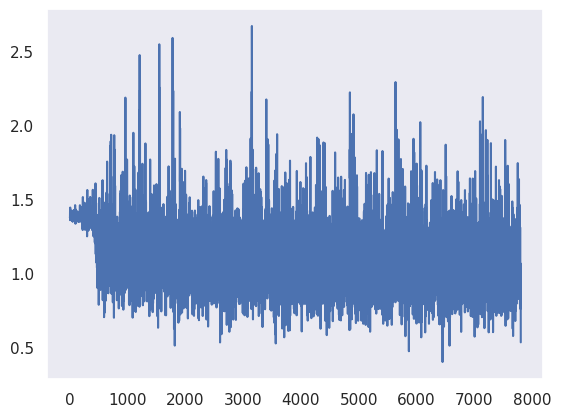

In [26]:
plt.plot(train_losses)

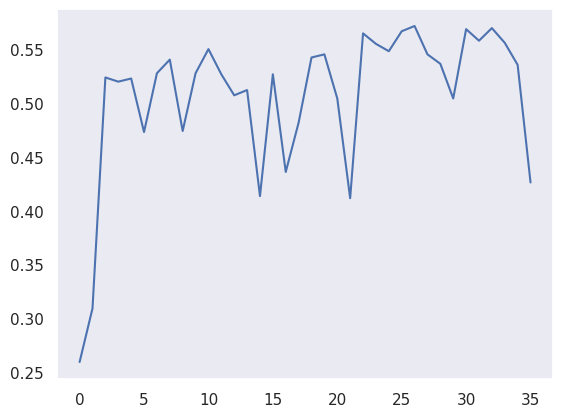

In [27]:
plt.plot(test_accuracy)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 100
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad4/cremad_label4_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()